# Final Project Models of Language Evolution
## Implementing a neural network for iterated learning
### Malin Spaniol and Sophia Schulze-Weddige

## 1 Preparations

In [82]:
# import packages
import numpy as np
import tensorflow as tf
import struct
import matplotlib.pyplot as plt

### 1.1 Create the dataset

The dataset consists of the signals, which serve as the input of the feed-forward model, and the meanings, which are the targets from which the model calculates its loss and learns. One can choose between different bottleneck sizes to test which number of utterances is ideal for compositionality to arise. In the paper the effect of 20, 50 and 2000 utterances are shown. For comparability we chose the same three examples for out graphs, but obviously one can chose any other size of the bottleneck and see how it effects the result.

The table size describes how many examples should be collected in the lookup table. To assure that each 256 possible signals occur at least once one would have to collect at least 1566.83 samples. This number is calculated by summing over the probability to get a signal that wasn't there before in each new sample. (1 + 256/255 + 256/254 + ... + 256/1)

In [112]:
# choose how many utterances one agent should learn from/generate
bottleneck_size = 50
# choose how big the lookup table should be
table_size = 2000


In tensorflow one can work with placeholders, which will be filled with real values during runtime. That means one creates a variable in the correct shape and data type and fills it with the values in each iteration of the training. We use placeholders for the signals and meanings. That way we can feed it with the dataset from the last generation and only have to build one neural net that can be trained over and over again for each generation.

The training data is cut into batches to improve computation time and avoid local minima.

In [113]:
tf.reset_default_graph()

# create placeholders for the signals and meanings
# these are being fed during runtime
signals = tf.placeholder(dtype = tf.float32, shape = (None, 8), name="Signal")
meanings = tf.placeholder(dtype = tf.float32, shape = (None, 8), name="Meaning")

# create the tensorflow dataset by matching the signals with the meanings
training_data = tf.data.Dataset.from_tensor_slices((signals, meanings))

# specify the batchsize 
batchsize = table_size
# fill the training batches 
training_data = training_data.batch(batchsize)

# create an iterator 
iterator = tf.data.Iterator.from_structure(training_data.output_types, training_data.output_shapes)

# name the operator that will get the next batch
next_batch = iterator.get_next()

# name the initialization operation
training_init_op = iterator.make_initializer(training_data)

# read out the meaning and signal from next batch
signal = next_batch[0]
meaning = next_batch[1]

### 1.2 Define the model

The model consists of two layers, the hidden layer and the output layer. Both layers have eight nodes and are fully connected. The activation of the output layer is a sigmoid function and weights are randomly initialized using the He initializer, which depends on the number of neurons of the previous layer (see references). The paper doesn't give any information about the activation function of the hidden layer, therefore we use the tangens hyperbolicus as it is a frequently used actiavtion function. The weights in the hidden layer are initialized using the Xavier initializer, which again depends on the number of neurons in the previous layer (or in our case the number of input neurons).
The paper doesn't give a any information about the initialization of the biases, therefore we use the golden standard and initialize them with zeros.

In [114]:
with tf.variable_scope("hidden_layer", tf.AUTO_REUSE):
    weights_in = tf.Variable(tf.random_normal(shape = (8,8), mean = 0.0, stddev = 0.36), dtype = tf.float32)
    bias_in = tf.Variable(tf.zeros([8]))
    drive = tf.matmul(signal,weights_in) + bias_in
    out = tf.nn.tanh(drive)

with tf.variable_scope("output_layer", tf.AUTO_REUSE):
    weights_out = tf.Variable(tf.random_normal(shape = (8,8), mean = 0.0, stddev = 0.6), dtype = tf.float32)
    bias_out = tf.Variable(tf.zeros([8]))
    logits = tf.matmul(out,weights_out) + bias_out
    outputs = tf.nn.sigmoid(logits)

### 1.3 Define the loss

Sigmoid Cross-Entropy loss is a Sigmoid activation plus a Cross-Entropy loss. Unlike Softmax loss it is independent for each vector component (class), meaning that the loss is computed for every output vector component and is not affected by other component values. That’s why it is used for multi-label classification, were the insight of an element belonging to a certain class should not influence the decision for another class. In our case the classes are 0 and 1 and we want to decide for each position in the 8-bit vector, whether it should be 1 or a 0.

In [115]:
# we use cross entropy to calculate the loss
cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=meaning)
loss = tf.reduce_mean(cross_entropy)

### 1.4 Define the optimizer

The optimizer we used is gradient descent. We also tried Adams optimizer but didn't get better results. We took the learning rate of 0.1 from the paper.

We use the size of the meaning space as a measure for the expressivity of the learned language of each generation. It is calculated by counting the number of different meanings in the output table.
Further, we calculate the mean squared difference between the output tables of two consecutive generations as a measure for stability of the language.

In [116]:
# define the optimizer which is used to minimize our loss
learning_rate = 0.1
# we use gradient descent as an optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)

# tell the optimizer what to optimize
training_step = optimizer.minimize(loss)

# we want to save the size of the meaning space and the difference between the meaning spaces of two generations
# as parameters for the goodness of the model/generation
# therefore we create empty lists which we fill with the relevant value in each generation
meaning_space = []
difference = []

## 2 Training the model

The first step is to generate the first signal-meaning pairs to start training the first agent. To achieve this we feed random signals in the model and save the generated outputs (=meanings) in a table. This is then fed into the for-loop of generations as the first "language" to be learned. In each generation the model is initialized with random weights again and then trained for 100 epochs. After the training is completed the same model is used to generate the new signal-meaning pairs for the next generation. Lastly, the goodness measures expressivity and stability are calculated and added to the lists.

In [117]:
with tf.Session() as lookup:
    # we don't need any targets, because we don't want to train the model yet
    # but the model es created in a way that it needs something for the placeholder "meanings"
    # therefore we create fake_meanings, which aren't used in any way 
    fake_meaning = np.zeros([table_size, 8])
    # generate random signals
    sig = np.random.randint(2, size = (table_size,8))
    # normalize the input 
    sig_norm = (sig-np.mean(sig,axis=0))/np.std(sig, axis=0)
    # initialize the variables
    lookup.run(tf.global_variables_initializer())
    # initialize the initializer
    lookup.run(training_init_op, feed_dict={signals: sig_norm, meanings: fake_meaning})
    # run the model and save the outputs in table
    signal_input, table = lookup.run((signal, outputs), feed_dict={signals: sig_norm, meanings: fake_meaning})
    # set a threshold at 0.5 ge get binary outputs
    table = np.where(table < 0.5, 0, 1)
    lookup.close()
    
# There is a training and a production phase 
# The training phase consists of 100 epochs, after that the parameters are set and the same model is used to
# produce the new dataset for the next agent

# Define the number of generations and epochs
generations = 250
epochs = 100

# Iterate over the generations
for _ in range(generations):
    
    # Start a new session and initialize the variables etc as before, but this time we don't take fake targets and random signals
    # but the ones the previous generation generated
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        global_step = 0
        
        # choose random pairs from the lookup table for training
        choice = np.random.choice(np.arange(table_size), bottleneck_size)
        # Iterate over the epochs
        for _ in range(epochs):

            sess.run(training_init_op, feed_dict= {signals:np.array(sig_norm[choice]),
                                                   meanings:np.array(table[choice])})
            # iterate through the whole dataset
            while True:
                try:
                    _, loss_value  = sess.run((training_step, loss), feed_dict= {signals:sig_norm[choice],
                                                                                 meanings:table[choice]})
                    global_step += 1
                
                    
                    #print("Training loss: {}".format(loss_value))
                
                except tf.errors.OutOfRangeError:
                    break
        
        # this part is to generate the dataset for the next generation
        # it works as in the first step
        global_step = 0
        fake_meaning = np.zeros([table_size, 8])
        #sig = np.random.randint(2, size = (table_size,8))
        # normalize the input 
        #sig_norm = (sig-np.mean(sig,axis=0))/np.std(sig, axis=0)
        sess.run(training_init_op, feed_dict= {signals:sig_norm,
                                               meanings:fake_meaning})
        table_last_gen = table.copy()
        signal_input, table = sess.run((signal, outputs), feed_dict={signals: sig_norm, meanings: fake_meaning})
        table = np.where(table < 0.5, 0, 1)
        # now we want to evaluate our learning process with the two parameter
        # 1. meaning_space = how many different meanings does this generation have in their lookup table
        # 2. diffence = how different are the languages between to generations
        meaning_space.append(len(np.unique(table,axis=0)))
        
        difference.append(np.mean((np.square(table_last_gen-table)).mean(axis=1)))

## 3 Plotting

### 3.1 Meaning space

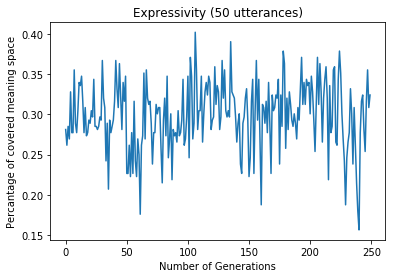

In [118]:
x = np.arange(len(meaning_space))
y = [meaning/256 for meaning in meaning_space]

plt.title("Expressivity (50 utterances)")
plt.xlabel("Number of Generations")
plt.ylabel("Percantage of covered meaning space")
plt.plot(x,y)

### 3.2 Difference between two consecutive generations

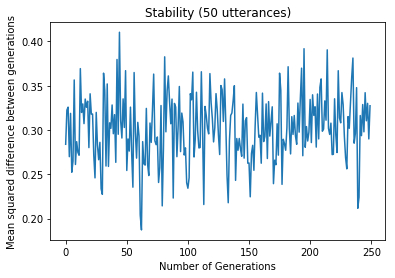

In [119]:
x = np.arange(len(difference))
y = difference

plt.title("Stability (50 utterances)")
plt.xlabel("Number of Generations")
plt.ylabel("Mean squared difference between generations")
plt.plot(x,y)